# Two-Particle Self-Consistent approach (TPSC) tutorial

This tutorial is done in four steps
1. We look at the momentum distribution curve at the Fermi level for the Green's function to check that there is perfect nesting.
2. We compute the Lindhard function for the non-interacting susceptibility and then in RPA to check the divergence at ($\pi,\pi)$.
3. Renormalized spin and charge vertices in TPSC are computed.
4. The spin susceptibility is computed to show that it does not diverge at finite temperature.

A challenging exercice with the self-energy is left at the end if you have time.

## Importing necessary modules and functions

In [1]:
from hubbardmodel import HubbardModel
import numpy as np
from scipy.optimize import newton, brentq
#from matplotlib import cm
#import matplotlib as mpl
#import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
import tpsc_util
from tpsc_util import density
%matplotlib inline
markers = ['s', 'o', '^', '>', 'v', '<', 'd', 'p', 'h', '8', '+', 'x']
import scipy
import warnings
warnings.simplefilter("ignore")

print("Tested on Windows with Python 3.5.5, numpy 1.13.3, scipy 0.19.0")
print("You have:")
print("    Python version =", sys.version)
print("    numpy version =",np.version.version)
print("    scipy version =",scipy.version.version)

print("Warnings have been removed. They happen in the Fourier transform.")
print("They did not seem to give any accuracy problem.")
print("They do not occur with certain versions.")
print("On Ubuntu with python 3.6.2, numpy 1.13.3, scipy 0.19.0, no error message occurs.")


Tested on Windows with Python 3.5.5, numpy 1.13.3, scipy 0.19.0
You have:
    Python version = 3.5.5 |Anaconda, Inc.| (default, Apr  7 2018, 04:52:34) [MSC v.1900 64 bit (AMD64)]
    numpy version = 1.11.3
    scipy version = 0.19.0
Warnings have been removed. They happen in the Fourier transform.
They did not seem to give any accuracy problem.
They do not occur with certain versions. 
On ubuntu with python 3.6.2, numpy 1.13.3, scipy 0.19.0, no error message occurs.


# 1. For nearest-neighbor model, the Fermi surface is nested

## 1.a Definition of the non-interacting Green's function and of a function that plots momentum distribution curves for that Green's function


\begin{equation}
G^R(\mathbf{k},\omega)=\frac{1}{\omega+i\eta-\epsilon(\mathbf{k})}
\end{equation}

with, in units where lattice spacing $a=1$,
\begin{equation}
\epsilon(\mathbf{k})=-2t(\cos{k_x}+\cos{k_y})
\end{equation}


In [2]:
def Green_2D(z, k):
    """
    Defines the lattice Green's function
    """
    x = np.array([1,0])
    y = np.array([0,1])
    return 1/(z - 2*(np.cos(np.tensordot(k,x,1))+np.cos(np.tensordot(k,y,1))))

def plot_mdc(Nk):
    """
    Plot the MDC for a grid with Nk x Nk points
    """
    basis = 2.*np.pi*np.eye(2)
    kgrid = np.linspace(0, 1, Nk, endpoint=False)
    k = np.meshgrid(*(2*(kgrid,)), indexing='ij')
    k = np.tensordot(np.transpose(basis), k, 1)
    k = np.rollaxis(k, 0, 3)
    G= Green_2D(0.05j, k)
    plt.imshow(-np.imag(G)/np.pi, cmap="jet",interpolation="nearest")
    plt.xticks([0,Nk/2, Nk],[r"0",r"$\pi$","$2\pi$",])    
    plt.yticks([0,Nk/2, Nk],[r"0",r"$\pi$","$2\pi$",])
    plt.xlabel(r"$k_x$")
    plt.ylabel(r"$k_y$")
    plt.title("Momentum distribution curve (MDC) at the Fermi level")


## 1.b Plot of the momentum distribution curve at the Fermi level

The Fermi surface is nested. 

    What do we mean by that?
    What is the nesting vector?


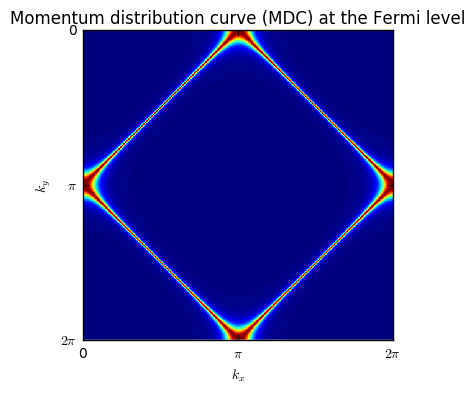

In [3]:
plot_mdc(500)

# 2. Non-interacting Lindhard function and RPA

## 2.a Computing the non-interacting Lindhard function $\chi_0$

The Lindhard function is defined by the following equation where, for short cut, $q=(\mathbf{q},iq_n)$ with $iq_n$ bosonic Matsubara frequencies and $k=(\mathbf{k},ik_n)$ with $ik_n$ fermionic Matsubara frequencies

\begin{equation}
\chi_0(q)=-2\frac{T}{N}\sum_{k} G_0(k)G_0(k+q) 
\end{equation}

This has the form of a convolution. So, to speed up the calculation, the evaluation is done by going to imaginary time and lattice positions for the Green's function with fast Fourier transforms (FFT) and performing the product

\begin{equation}
\chi_0(\mathbf{r},\tau)=G_0(\mathbf{r},\tau)G_0(-\mathbf{r},-\tau)
\end{equation}

One finally goes back to momentum and Matsubara frequency space by fast Fourier transforms on $\chi(\mathbf{r},\tau)$

NOTE: One also often denotes the Lindhard function by $\Pi$, the polarisation. This is the convention in the code.

    How many operations are saved by using this trick of fast Fourier transforms?
    At what wavevector is the maximum of the Lindhard function at zero frequency?
    How is the postiion of that maximum related to the Fermi surface?
    Can you plot the function at different temperatures and understand what happens physically?
    What happens if you increase U?
    

In [4]:
# Number of Matsubara frequencies. Must be a power of 2 for FFT. 
# With the negative parts, we have here twice as many frequencies.
nfreq = 512  
# Number of k vectors in one direction. In total, we have length^d points with d=dimension
length = 120 
# Model contains the dictionary that specifies the value of the parameters of the model
model = HubbardModel({'t': 1, 'MU': 0., 'T': 0.75, 'U': 4, 'DIMENSIONS': 2})
# Grid for FFT in maginary time
taugrid = np.linspace(0,model.beta,nfreq,endpoint=True) 
# This is the Lindhard function
piwq = 2 * tpsc_util.ph_bubble(model, taugrid, length,include_tail=False) #Calcul de la fonction de Lindhard. 


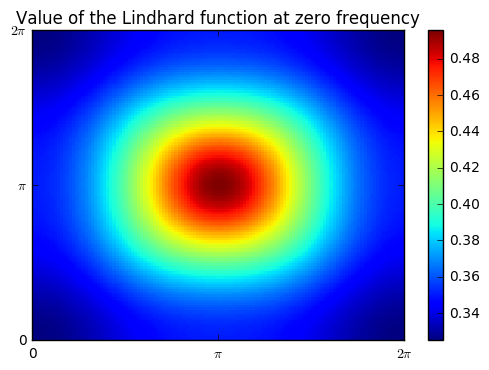

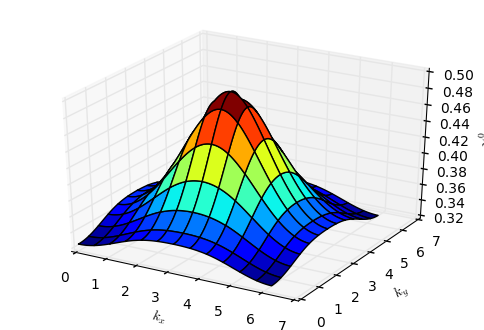

In [5]:
#This draws the Lindhard function in two different ways. 
#%matplotlib notebook
#%matplotlib notebook 
# matplotlib inline does not allow one to manipulate the figures
%matplotlib inline

# Here is a colorplot map
plt.pcolor(np.real(piwq[0,:,:]), cmap="jet")
plt.xticks([0,length/2, length],[r"0",r"$\pi$",r"$2\pi$"])    
plt.yticks([0,length/2, length],[r"0",r"$\pi$",r"$2\pi$"])
plt.colorbar()
plt.title("Value of the Lindhard function at zero frequency")

# Here is a 3d plot. With "matplotlib inline" one cannot interact
kgrid = np.linspace(0,2*np.pi,length,endpoint=False) 
hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
X, Y = np.meshgrid(kgrid, kgrid)  # `plot_surface` expects `x` and `y` data to be 2D
ha.plot_surface(X, Y, np.real(piwq[0,:,:]),cmap="jet")
ha.set_xlabel(r"$k_x$")
ha.set_ylabel(r"$k_y$")
ha.set_zlabel(r"$\chi^{0}$")


## 2.b RPA susceptibility

The RPA spin susceptibility is defined by

\begin{equation}
\chi_{sp}(q)=\frac{\chi_0(q)}{1-\frac{U}{2}\chi_0(q)}.
\end{equation}

The charge susceptibility on the other hand is 
\begin{equation}
\chi_{ch}(q)=\frac{\chi_0(q)}{1+\frac{U}{2}\chi_0(q)}.
\end{equation}

It is a sort of Lindhard function for interacting problems. 
It is computed and plotted below.

    Why does it become larger than the non-interacting value?
    At what temperature does it diverge?
    If you decrease the value of $U$ to $U=3$, at what temperature does this divergence occur?
    Can you plot the charge susceptibility for the same parameters?
    Why physically is the charge susceptibility decreasing with $U$ while the spin susceptibility increases?
    

In [6]:
pisp = piwq/(1-0.5*model.u*piwq)

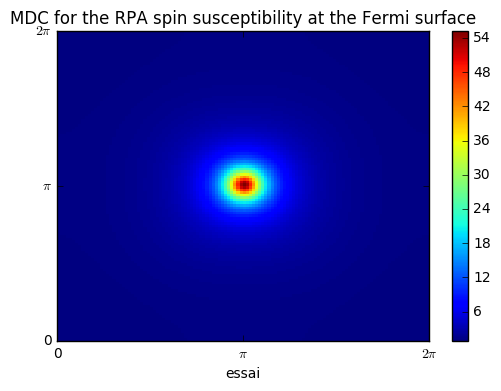

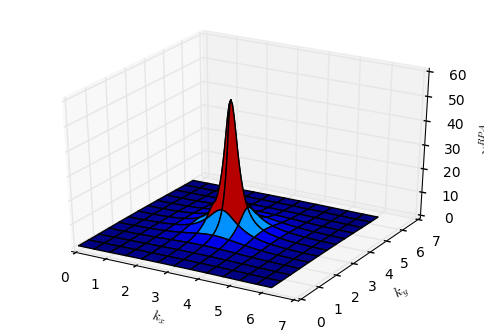

In [7]:
#%matplotlib notebook
#%matplotlib notebook 
%matplotlib inline

plt.pcolor(np.real(pisp[0,:,:]), cmap="jet")
plt.xticks([0,length/2, length],[r"0",r"$\pi$",r"$2\pi$"])    
plt.yticks([0,length/2, length],[r"0",r"$\pi$",r"$2\pi$"])
plt.colorbar()
plt.title("MDC for the RPA spin susceptibility at the Fermi surface")

plt.xlabel(r"essai")
hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')
X, Y = np.meshgrid(kgrid, kgrid)  # `plot_surface` expects `x` and `y` data to be 2D
ha.plot_surface(X, Y, np.real(pisp[0,:,:]),cmap="jet")
ha.set_xlabel(r"$k_x$")
ha.set_ylabel(r"$k_y$")
ha.set_zlabel(r"$\chi^{RPA}$")

# 3. Renormalized spin and charge vertices in TPSC

# 3.a Definition of functions for TPSC

The following functions are used to solve the TPSC equations. 

Comments are given for each function.

NOTE: Most of the numerical work is done in the imported modules

### Sum rules for spin and charge susceptibilities

The following two functions perform the sums over Matsubara frequency $iq_n$ and wave vectors $\mathbf{q}$ of, respectively, the spin and charge susceptibilities that are used in sum rules 

\begin{equation}
\frac{T}{N}\sum_{\mathbf{q},iq_n} \frac{\chi_0(\mathbf{q},iq_n)}{1\mp\frac{U_{sp,ch}}{2}\chi_0(\mathbf{q},iq_n)}
\end{equation}

In this expression, $\chi_0(\mathbf{q},iq_n)$ is the Lindhard function for the non-interacting problem. 


In [8]:
def chisp(u,chi0,beta):
    '''
    Computes the sum over Matsubara frequency and wave vector of the spin susceptibility, 
    \sum \frac{\chi_0}{1-0.5*U_{sp}*\chi_0}
    The 0.5 comes from the convention used for the Lindhard function \chi^0
    '''
    nq = chi0[0].size
    return 1./(beta*nq) * ( chi0 / (1-0.5*u*chi0) ).sum()

def chich(u,chi0,beta):
    '''
    Computes the sum over Matsubara frequency and wave vector of the charge susceptibility, 
    \sum \frac{\chi_0}{1+0.5*U_{ch}*\chi_0}
    '''
    nq = chi0[0].size
    return 1./(beta*nq) * ( chi0 / (1+0.5*u*chi0) ).sum()



### This function is a root finder that is used to solve the self-consistency equation 

This function takes a Newton method or falls back on the Brent method if Newton fails to converge.

In [9]:
def root(f,x0,tol=1e-5,maxiter=500):
    """
    Finds the root of f(x). If the Newton algorithm fails, we ball back on Brent
    """
    x = newton(f,x0,tol=tol,maxiter=maxiter)
    fx = f(x)
    if abs(fx) > tol:
        print(('newton failed to find root [f({})={} != 0]. falling back on brent.'.format(x,fx)))
        x = brent(lambda x: abs(f(x)),tol=tol,maxiter=maxiter)
    return x


### This function calls the root finder to solve the self-consistency equation

The sum-rule that gives the self-consistency equation is

\begin{equation}
\frac{T}{N}\sum_{\mathbf{q},iq_n} \frac{\chi_0(\mathbf{q},iq_n)}{1-\frac{U_{sp}}{2}\chi_0(\mathbf{q},iq_n)}=n-2\left< n_\uparrow n_\downarrow\right>
\end{equation}

with the ansatz

\begin{equation}
U_{sp}\left<n_\uparrow\right> \left<n_\downarrow\right>=U\left<n_\uparrow n_\downarrow\right>.
\end{equation}

Given the double occupancy, the charge vertex can then be obtained from

\begin{equation}
\frac{T}{N}\sum_{\mathbf{q},iq_n} \frac{\chi_0(\mathbf{q},iq_n)}{1+\frac{U_{cn}}{2}\chi_0(\mathbf{q},iq_n)}=n+2\left< n_\uparrow n_\downarrow\right>-n^2.
\end{equation}


In [10]:
def tpsc(model,nfreq,length):
    """
    This function solves the TPSC self-consistency equation for given "model" parameters.
    We need to specify "nfreq", the number of Matsubara frequencies used in the sum rule,
    as well as "length", the number of wave vectors.
    It returns the density, the double occupancy, as well as U_sp and U_ch
    """
    # This writes a dot every time the function is called
    sys.stdout.write('.'); sys.stdout.flush()
    # discretize imaginary time to compute susceptibilities with FFT
    taugrid = np.linspace(0,model.beta,nfreq,endpoint=True)
    # Computes the non-interacting Lindhard function
    piwq = 2 * tpsc_util.ph_bubble(model, taugrid, length)  # , include_tail=False, fitspline=False)
    # TPSC step 1 
    # We need the density. 
    dens = density(model,length)
    # First, if U=0, we know the double occupancy.
    if model.u == 0:    return (dens,dens/4.,0,0)
    # We can now compute the self-consistent value of U_sp using the root finder Brent. 
    # We can either choos U_sp or double occupancy as the quantity that is determined self-consistently
    # Here, it is U_sp that is used
    usp = brentq(lambda us: np.real(chisp(us,piwq,model.beta)) + 0.5*us/model.u*dens**2 - dens,
                 0, 2./np.max(piwq[0].real) - 1e-10)  # , tol=1e-2)
    # Now that we have U_sp, we can compute double-occupancy
    docc = 0.25*usp/model.u * dens**2
    # U_ch can finally be obtained with the sum rule, using the root finder defined above 
    uch = root(lambda uc: np.real(chich(uc,piwq,model.beta)) - 2*docc - dens + dens**2, model.u)  # , tol=1e-2)
    # sigma1 = 4*model.u*docc/dens**2 * dens
    return (dens,docc,usp,uch)



## 3.b Our main task here: compute the renormalized spin and charge vertices in TPSC

We reproduce the following figure from the __[paper](https://jp1.journaldephysique.org/articles/jp1/abs/1997/11/jp1v7p1309/jp1v7p1309.html)__
<img src="./img/Fig2.png" alt="Drawing" style="width: 250px;"/> by calling the function tpsc for a grid of values of the bare U.


In [11]:
# Number of Matsubara frequencies. Must be a power of 2 because of FFT.
nfreq = 512  
# Number of wave vectors
length = 50
# Defines the grid for the values of U that will be computer# To be done
ugrid = np.linspace(0,5,11)
# Calls the tpsc function for the values of U in ugrid
scaninU = [tpsc(HubbardModel({'t': 1, 'MU': 0, 'T': 0.4, 'U': u, 'DIMENSIONS': model.dims}), nfreq, length)
           for u in ugrid]

...........

In [12]:
# With python zip, "dens" will now be a tuple containing the results of each iteration. 
# Similarly for the other three variables. 
dens,docc,usp,uch = list(zip(*scaninU))

Here is the desired plot.

    What is the value of temperature for that plot?
    Why is U_sp saturating?
    What does that tell us about the domain of validity of TPSC?
    Can you make a similar plot for the double occupancy and interpret the results?
    Given that result, can TPSC describe the Mott transition and why?

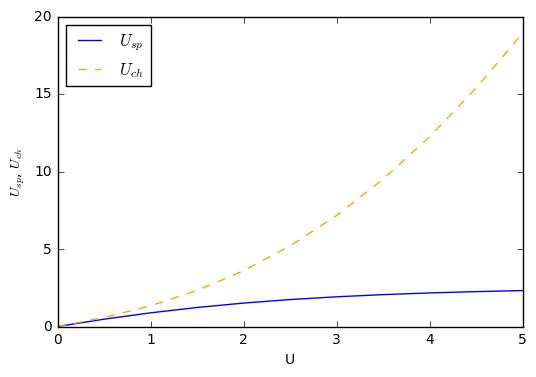

In [13]:
%matplotlib inline
%matplotlib inline
# The results are now plotted for the values of U in ugrid
plt.plot(ugrid, usp,"-",color="blue", label=r"$U_{sp}$")
plt.plot(ugrid, uch, "--", color="orange", label=r"$U_{ch}$")
plt.xlabel("U")
plt.ylabel(r"$U_{sp}$, $U_{ch}$")
plt.legend(loc="best")

### Note: weakness of RPA

Given the above sum rules, note that in TPSC the following sum-rule, a consequence of the Pauli principle, is satisfied:

\begin{equation}
\frac{T}{N}\sum_{\mathbf{q},iq_n} \left (\frac{\chi_0(\mathbf{q},iq_n)}{1-\frac{U_{sp}}{2}\chi_0(\mathbf{q},iq_n)}+\frac{\chi_0(\mathbf{q},iq_n)}{1+\frac{U_{ch}}{2}\chi_0(\mathbf{q},iq_n)}\right)=2n-n^2.
\end{equation}

Note that the right-hand side is independent of interactions.

    Compute the same quantity, but in the RPA approximation, 
    and make a plot of how much RPA violates the Pauli principle.


# 4. The TPSC spin susceptibility satisfies the Mermin-Wagner theorem

We will reproduce the top panel of the figure below, taken from the same __[paper](https://jp1.journaldephysique.org/articles/jp1/abs/1997/11/jp1v7p1309/jp1v7p1309.html)__ :
<img src="./img/Fig7.png" alt="Drawing" style="width: 250px;"/>

This time we fix $U=4$ and vary temperature. Using the ansatz $U_{sp}\left<n_\uparrow\right> \left<n_\downarrow\right>=U\left<n_\uparrow n_\downarrow\right>$, the spin susceptibility obeys

\begin{equation}
\frac{T}{N}\sum_{\mathbf{q},iq_n} \frac{\chi_0(\mathbf{q},iq_n)}{1-\frac{U\left<n_\uparrow n_\downarrow\right>}{2\left<n_\uparrow\right> \left<n_\downarrow\right>}\chi_0(\mathbf{q},iq_n)}=n-2\left< n_\uparrow n_\downarrow\right>
\end{equation}

When the susceptibility increases, $\left<n_\uparrow n_\downarrow\right>$ on the right-hand side decreases, but then the denominator of the spin susceptibility will lead to a decreas in susceptibility.

More rigorously, we can see that dimension is important here. The right-hand side of the equation cannot diverge. Also, on the left-hand side, note that the most divergent contribution is the zero Matsubara frequency, as one can see from the spectral representation and $\chi''(\mathbf{q},\omega)=-\chi''(\mathbf{q},-\omega)$

\begin{equation}
\chi(\mathbf{q},iq_n)=\int \frac{d\omega}{\pi}\frac{\chi''(\mathbf{q},\omega)}{\omega-iq_n}=\int \frac{d\omega}{\pi}\frac{\omega\chi''(\mathbf{q},\omega)}{\omega^2+q_n^2}.
\end{equation}

Using these results, the non-singular finite Matsubara frequency terms can be put on the right-hand side of the sum rule and all that is left is 

\begin{equation}
T\int d^2q \frac{a}{\xi^{2}+q^2}\sim C(T)
\end{equation}

where we have expanded the susceptibility around $(\pi,\pi)$, gone from sum to integral and shifted the origin of integration so that now $\mathbf{q}$ is the deviation from $(\pi,\pi)$. On dimensional grounds, the left-hand side is logarithmic in two dimensions so that the correlation length scales like $\exp(C'(T)/T)$.

In [14]:
Tgrid = np.linspace(0.20,1,16,endpoint=True)
scaninT = [tpsc(HubbardModel({'t': 1, 'MU': 0, 'T': t, 'U': 4, 'DIMENSIONS': model.dims}), nfreq, length)
           for t in Tgrid]

................

In [15]:
# dens will become a tuple containing the results of the iterations. Same thing for the other variables.  
dens,docc,usp,uch = list(zip(*scaninT))

In [16]:
Chipipi = []
for i in range(len(Tgrid)):
    # This writes a dot every time the function is called
    sys.stdout.write('.'); sys.stdout.flush()
    #print("Temperature = ", round(Tgrid[i],2))
    taugrid = np.linspace(0,1./Tgrid[i],nfreq,endpoint=True) #Temps imaginaire
    piwq = 2*tpsc_util.ph_bubble(HubbardModel({'t': 1, 'MU': 0, 'T': Tgrid[i], 'U': 4, 'DIMENSIONS': model.dims}),taugrid, length)
    Chipipi.append(piwq[0,length//2-1,length//2-1]/(1-0.5*usp[i]*piwq[0,length//2-1,length//2-1]))
print()
print(Tgrid)

................
[ 0.2         0.25333333  0.30666667  0.36        0.41333333  0.46666667
  0.52        0.57333333  0.62666667  0.68        0.73333333  0.78666667
  0.84        0.89333333  0.94666667  1.        ]


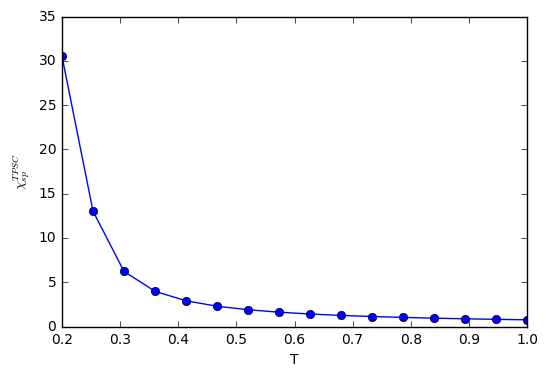

In [17]:
plt.plot(Tgrid,np.real(Chipipi),"o-")
plt.xlabel(r"T")
plt.ylabel(r"$\chi^{TPSC}_{sp}$")

### Comparison with original figure

    The original figure is for the spin structure factor. 
    To make a faire comparison, can you compute that quantity, 
        which is the sum over Matsubara frequencies of the susceptibility at the same wave vector?

### Comparison with RPA

    RPA will lead to a phase transition around $T=0.75$. 
    Can you plot the RPA result on the same figure (watch for divergences)?
    $U$ is renormalized at high-temperature by Kanamori-Brückner screening, as we have seen in the previous section.

# 5. Extra exercise if you have time: Self-energy and hot spots

In electron-doped cuprates near optimal doping, the MDC spectral function at the Fermi energy found experimentally in this paper 
__[paper](https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.87.147003)__,
looks as follows (Fig. 2):
<img src="./img/Armitage_experiment_fig2.PNG" alt="Drawing" style="width: 250px;"/>
The EDC taken by following the Fermi surface contour is given in Fig. 3c: 
<img src="./img/Armitage_experiment_fig3c.PNG" alt="Drawing" style="width: 250px;"/>


The calculation with TPSC is done by using the following formula for the self-energy at the second level of approximation. The formula can be found in Eq.(3) of the following __[paper](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.61.7887)__:
\begin{equation}
\Sigma^R(\mathbf{k},\omega)= Un_{\sigma}+\frac{T}{N}\frac{U}{8}\sum_{\mathbf{q},\omega'}\left[\left(3U_{sp}\chi_{sp}(\mathbf{q},\omega')+U_{ch}\chi_{ch}(\mathbf{q},\omega')\right)G_0^R(\mathbf{k}+\mathbf{q},\omega+\omega')\right].
\end{equation}
A fast evaluation again relies on using the fast Fourier transform trick. This can be done starting from the Matsubara frequency version of the above expression and using Padé to find the final answer. 

Parameters $t’=0.175t$ and $t’’=0.05t$, $U=5.75t$, $\beta=20$ yield the following EDC along the Fermi surface
<img src="./img/EDC_kyung.PNG" alt="Drawing" style="width: 250px;"/>
and the following MDC at the Fermi energy (on the first quadrant of theBrillouin zone instead of the fourth as in experiment):
<img src="./img/MDC_Kyung.PNG" alt="Drawing" style="width: 250px;"/>.

With an experimental energy resolution of 10 meV, if we take $t=350$ meV, then $\eta = 0.03t$. The filling is $n=1.15$. 

## Notes:

1. The above self-energy is the second level of approximation for TPSC. At the first level, the Green's function and the self-energy take the non-interacting form. In other words, there is a constant self-energy which is compensated by a chemical potential shift.
2. The self-energy at the second level of approximation obeys the following consistency condition between one and two-particle quantities: $\rm{Tr}\Sigma G_0=U < n_\uparrow n_\downarrow > $. If we define $G$ as containing the above self-energy, then $\rm{Tr}\Sigma G$ deviates from $U < n_\uparrow n_\downarrow >$. When the deviation becomes important, this indicates that we are beyond the domain of validity of the theory.